In [1]:
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn
from modules import EDMPrecond
from diffusion import *
from utils import *
from evaluate import *
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from tabulate import tabulate

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Make predictions on test data

In [3]:
path = "models/edm_e300_bs16_do0_no-cg/ema_ckpt.pt"
print("Loading: ", path)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = EDMPrecond(resolution   = 1024,
                   channels    = 1,
                   label_dim       = 3,
                   use_fp16        = False,
                   sigma_min       = 0,
                   sigma_max       = float('inf'),
                   sigma_data      = 0.5,
                   model_type      = 'UNet_conditional',
                   device=device
                    ).to(device)
ckpt = torch.load(path,
                  map_location=device,
                  weights_only=True
                  )
model.load_state_dict(ckpt)

sampler = EdmSampler(net=model, num_steps=100)

Loading:  models/edm_e300_bs16_do0_no-cg/ema_ckpt.pt
Using device: cuda:0


In [4]:
x_real, cond_vectors, predictions = evaluate(model,
                      sampler,
                      device,
                      "../data/test_data_1024_[-1,1].csv",
                                            s_type='edm'
                                            )
x_real = np.array(x_real)
cond_vectors = np.array(cond_vectors)
predictions = np.array(predictions)

Testing loop: 100%|███████████████████████████████████████| 1567/1567 [47:27<00:00,  1.82s/it]


In [5]:
mse = np.mean((x_real - predictions) ** 2)
print(f"Mean test mse error: {mse}")

Mean test mse error: 0.004770381226813015


In [ ]:
x_real

In [ ]:
predictions

In [ ]:
predictions[:, 0, 0, :]

In [ ]:
cond_vectors

# Save predictions

In [6]:
x_real_str = [','.join(map(str, row)) for row in x_real]
cond_vectors_str = [','.join(map(str, row)) for row in cond_vectors]
preds_str = [','.join(map(str, row)) for row in predictions[:, 0, 0, :]]

df = pd.DataFrame({'x_real': x_real_str, 'cond_vectors': cond_vectors_str, 'predictions': preds_str})
df.to_csv('results/predictions/preds_edm_e300_bs16_do0_no-cg.csv', index=False)

In [7]:
df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3163244128227234,0.3391146957874298,0.0","-0.9990509748458862,-0.9993624687194824,-0.999..."
1,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.27736008167266846,0.44142237305641174,0.0","-0.9978458285331726,-0.9983664155006409,-0.998..."
2,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.6772092580795288,0.2812798023223877,0.0","-0.9990798234939575,-0.9994442462921143,-0.999..."
3,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.5888327956199646,0.7273106575012207,0.0","-0.9990642666816711,-0.9999154210090637,-0.999..."
4,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3009049892425537,0.22526775300502777,0.0","-0.998763918876648,-0.9990586042404175,-0.9990..."


In [8]:
# Load data
df = pd.read_csv('results/predictions/preds_edm_e300_bs16_do0_no-cg.csv')

# Function to convert comma-separated strings to lists of floats
def str_to_float_list(s):
    return np.array(list(map(float, s.split(','))))

x_real = np.array([str_to_float_list(row) for row in df['x_real']])
cond_vectors = np.array([str_to_float_list(row) for row in df['cond_vectors']])
predictions = np.array([str_to_float_list(row) for row in df['predictions']])

df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3163244128227234,0.3391146957874298,0.0","-0.9990509748458862,-0.9993624687194824,-0.999..."
1,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.27736008167266846,0.44142237305641174,0.0","-0.9978458285331726,-0.9983664155006409,-0.998..."
2,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.6772092580795288,0.2812798023223877,0.0","-0.9990798234939575,-0.9994442462921143,-0.999..."
3,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.5888327956199646,0.7273106575012207,0.0","-0.9990642666816711,-0.9999154210090637,-0.999..."
4,"-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-...","0.3009049892425537,0.22526775300502777,0.0","-0.998763918876648,-0.9990586042404175,-0.9990..."


# Intro into data

In [9]:
# Find indices and values greater than 0.5
indices = np.where(np.any(x_real > 0.5, axis=1))[0]
filtered_values = [x_real[idx][x_real[idx] > 0.5] for idx in indices]
filtered_predictions = [predictions[idx][x_real[idx] > 0.5] for idx in indices]

# Flatten results and take the first 50
flat_filtered_values = np.concatenate(filtered_values)[:50]
flat_filtered_predictions = np.concatenate(filtered_predictions)[:50]

# Print the results side by side
print("Filtered Values (greater than 0.5) from x_real and corresponding Predictions:")
for value, prediction in zip(flat_filtered_values, flat_filtered_predictions):
    print(f"{value:.5f}\t\t\t{prediction:.5f}")

Filtered Values (greater than 0.5) from x_real and corresponding Predictions:
0.51407			0.49221
0.65096			0.63090
0.78482			0.75487
0.89267			0.85771
0.97221			0.93871
1.00000			1.00000
1.00000			0.95963
1.00000			0.99961
0.96727			0.92549
0.82849			0.79485
0.73080			0.69777
0.61790			0.58454
0.52190			0.48362
0.55391			0.57857
0.67699			0.70440
0.78227			0.81348
0.87054			0.89996
0.94814			0.98505
0.91525			0.94609
0.96301			1.00000
0.90360			0.93895
0.78227			0.81695
0.70256			0.73830
0.59787			0.62548
0.50855			0.53528
0.54796			0.54214
0.68742			0.68224
0.81460			0.80053
0.90345			0.88980
0.95629			0.94507
1.00000			1.00000
0.93835			0.93179
0.95377			0.95233
0.87022			0.86630
0.72938			0.72515
0.62246			0.62025
0.50288			0.50141
0.54077			0.53937
0.68126			0.68507
0.81203			0.81306
0.91680			0.91178
0.97169			0.97514
1.00000			1.00000
0.97584			0.98502
1.00000			0.99759
0.92773			0.92991
0.78535			0.79323
0.68151			0.68708
0.56501			0.57422
0.60578			0.63740


In [10]:
# Find indices where predictions > 0.8 and corresponding x_real < 0.5
indices = np.where((predictions > 0.8) & (x_real < 0.1))

# Extract filtered values from x_real and predictions
filtered_x_real = x_real[indices]
filtered_predictions = predictions[indices]

# Print the results side by side
print("Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):")
for x_val, pred_val in zip(filtered_x_real.flatten(), filtered_predictions.flatten()):
    print(f"{x_val:.5f}\t\t\t{pred_val:.5f}")

Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):


# Visualization of results

In [11]:
wavelengths = np.load('../data/wavelengths.npy')

In [12]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

## Plot predictions

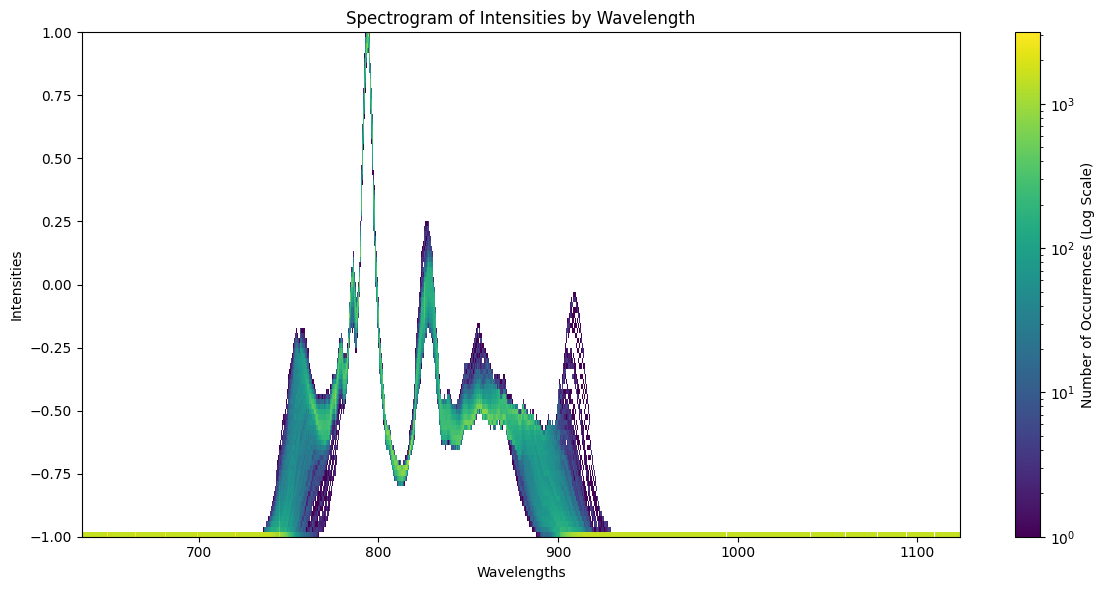

In [13]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

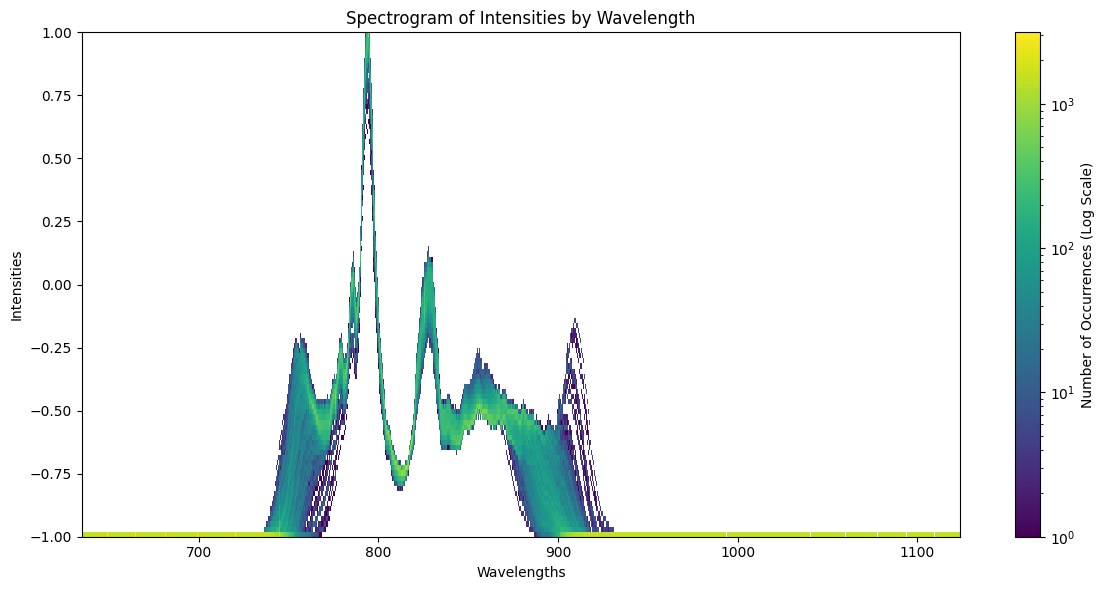

In [14]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")

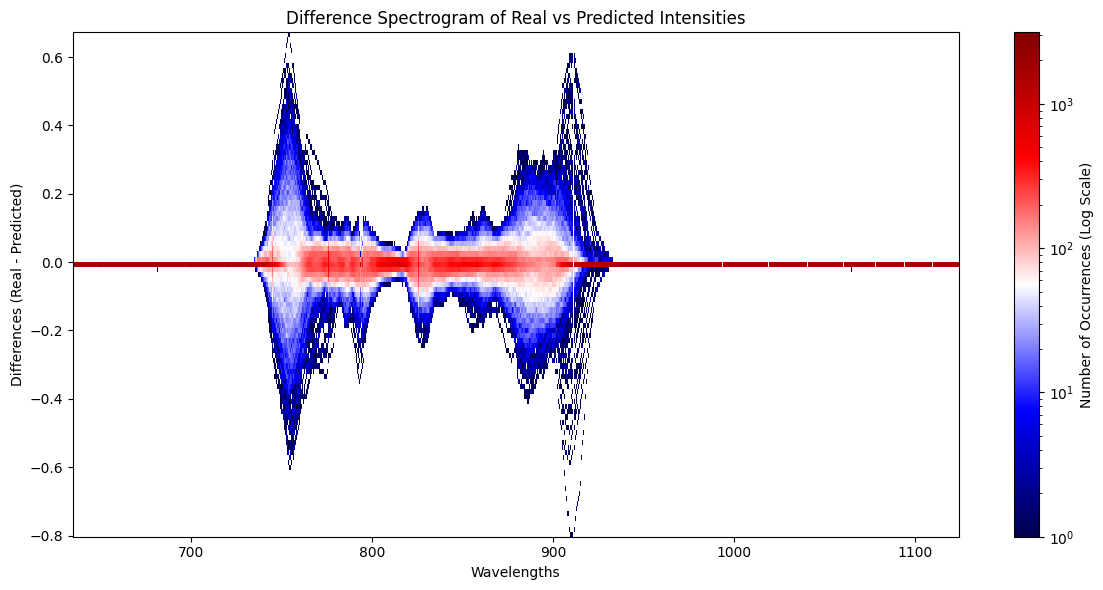

In [15]:
create_difference_spectrogram(wavelengths, 
                              x_real, 
                              predictions, 
                              label="Difference Spectrogram of Real vs Predicted Intensities")

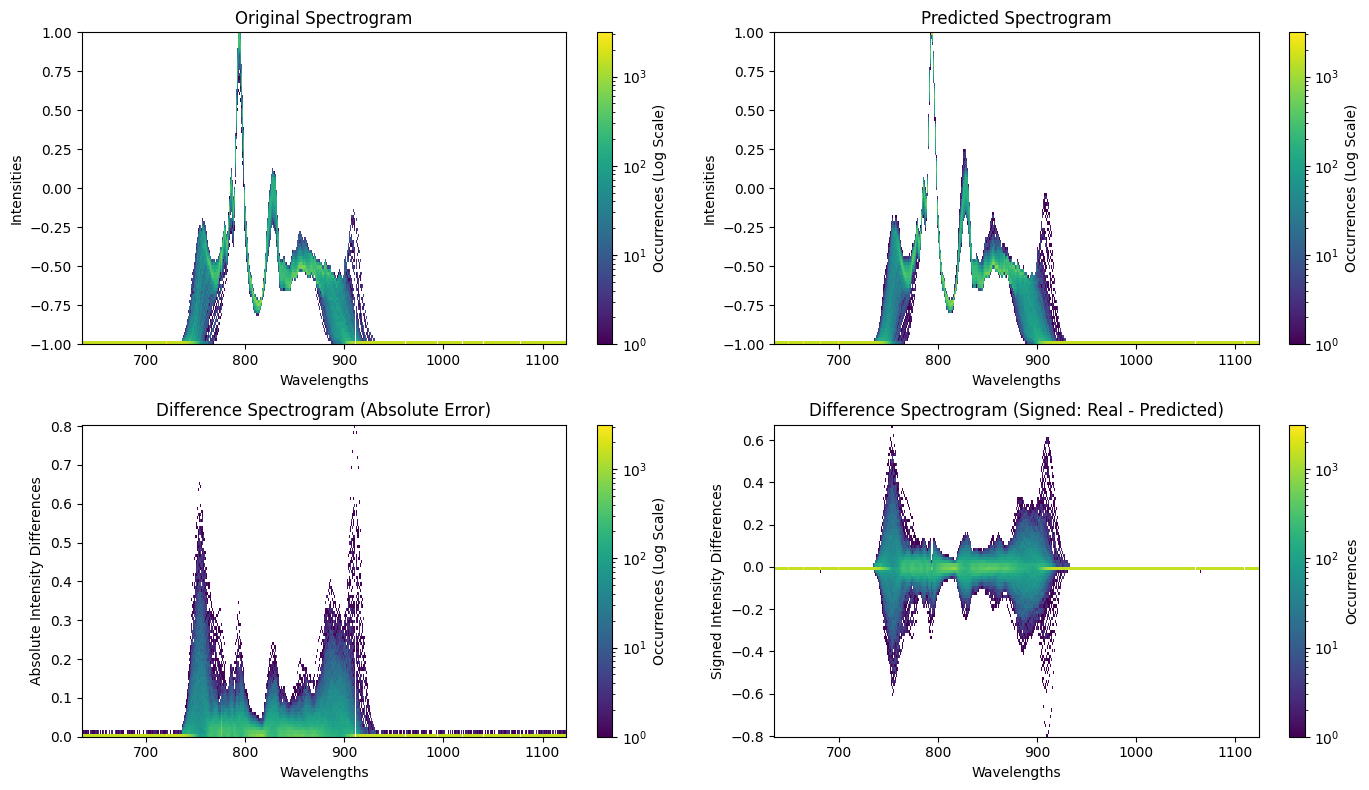

In [16]:
create_combined_spectrogram(wavelengths, 
                            x_real, 
                            predictions)

## Influence of parameters to predictions

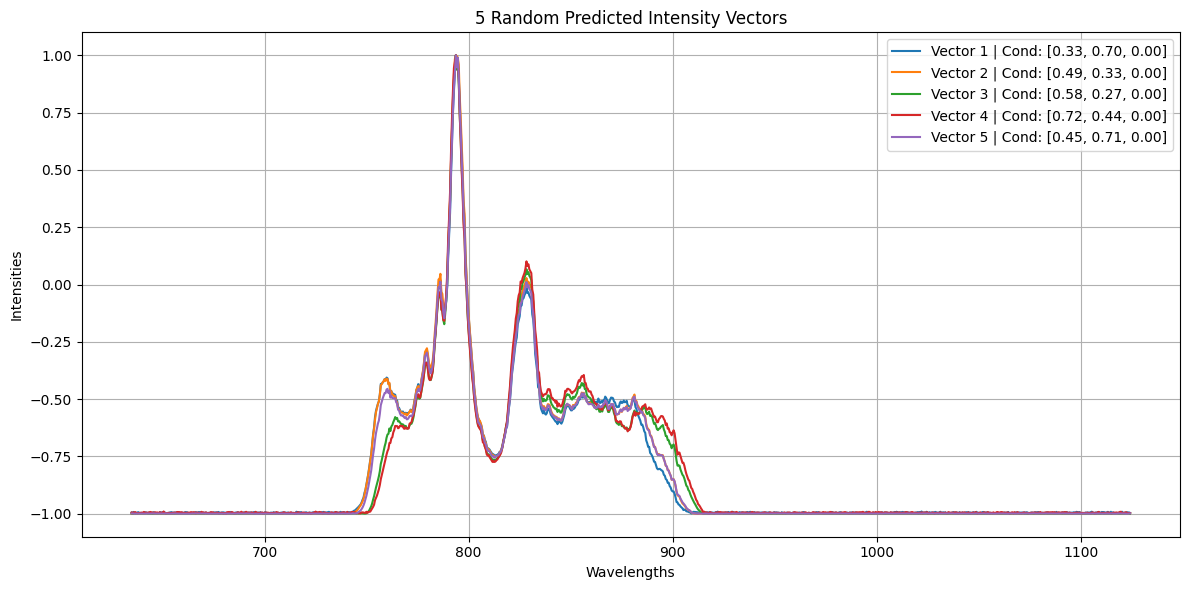

In [17]:
plot_random_intensity_vectors(wavelengths, predictions, cond_vectors)

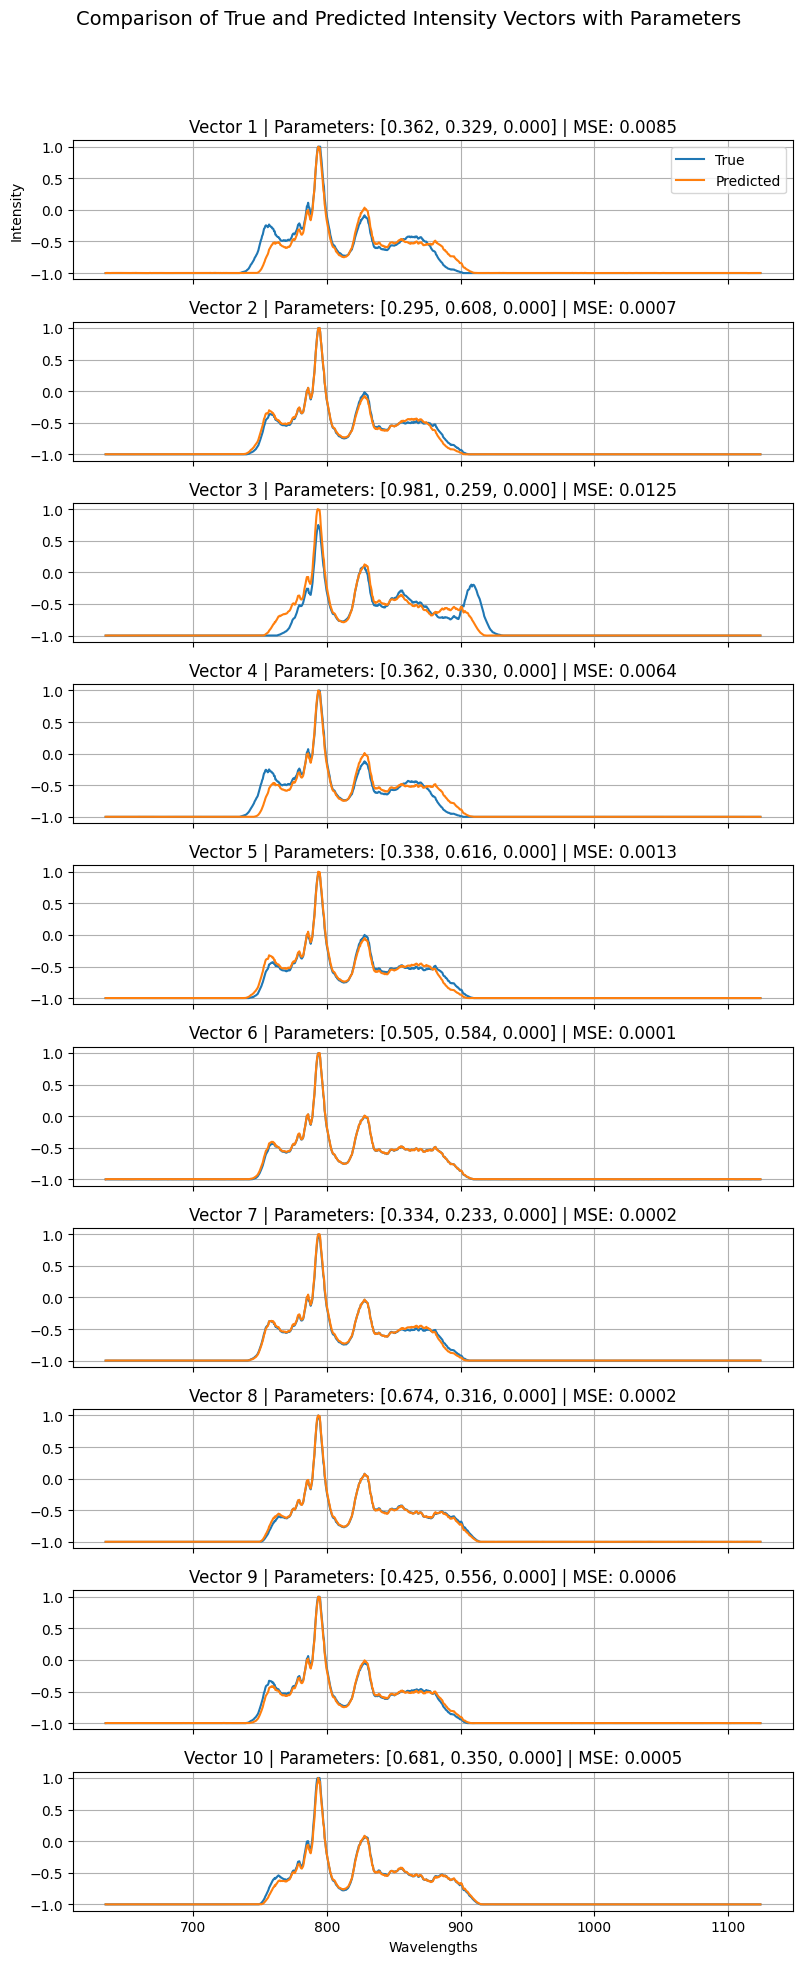

In [18]:
indices = np.random.choice(len(x_real), size=10, replace=False)

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=10
)

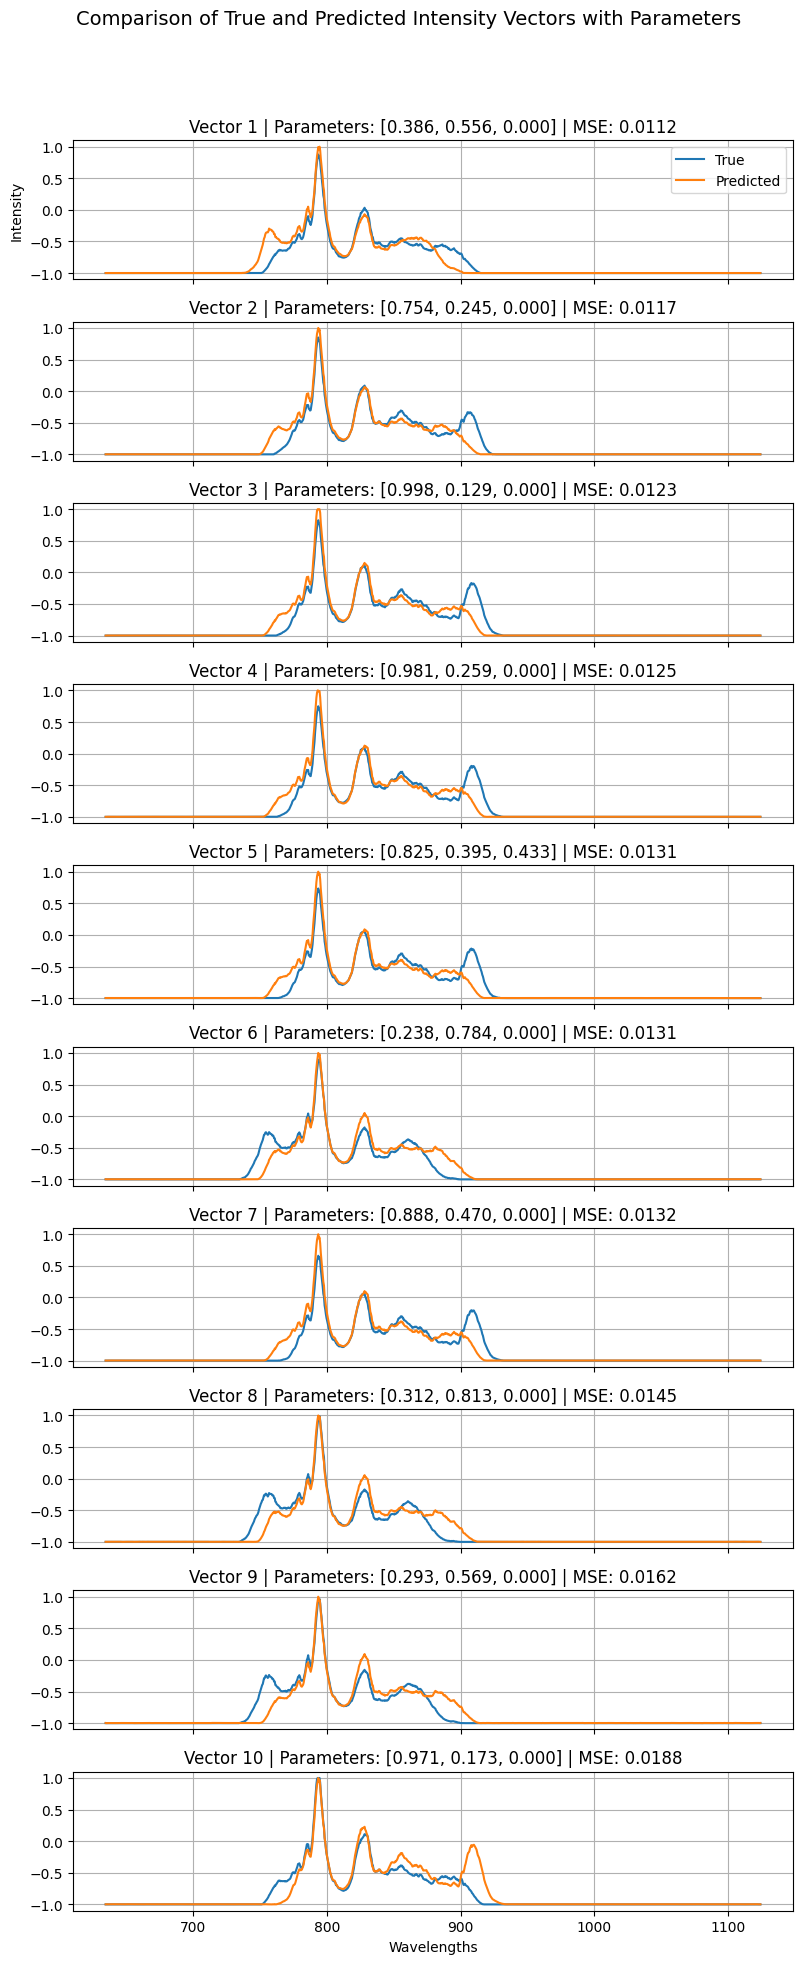

In [19]:
worst_indices = get_worst_mse_indices(x_real, predictions, n=10)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, worst_indices, num_vectors=10
)

MSE Statistics:
Mean: 0.0016
Median: 0.0008
Standard Deviation: 0.0021
Min: 0.0000
Max: 0.0188
Range: 0.0188
Median (Q2): 0.0008
First Quartile (Q1): 0.0003
Third Quartile (Q3): 0.0021
Interquartile Range (IQR): 0.0018
Upper Whisker: 0.0049
Number of Outliers: 110.0000
Outliers: [0.004904260937682318, 0.008071683500302025, 0.005454861789887773, 0.01616869639950894, 0.005162922694222563, 0.005557626977069094, 0.005583580347641472, 0.0055168122926161365, 0.011027102276163277, 0.013240146853608387]...


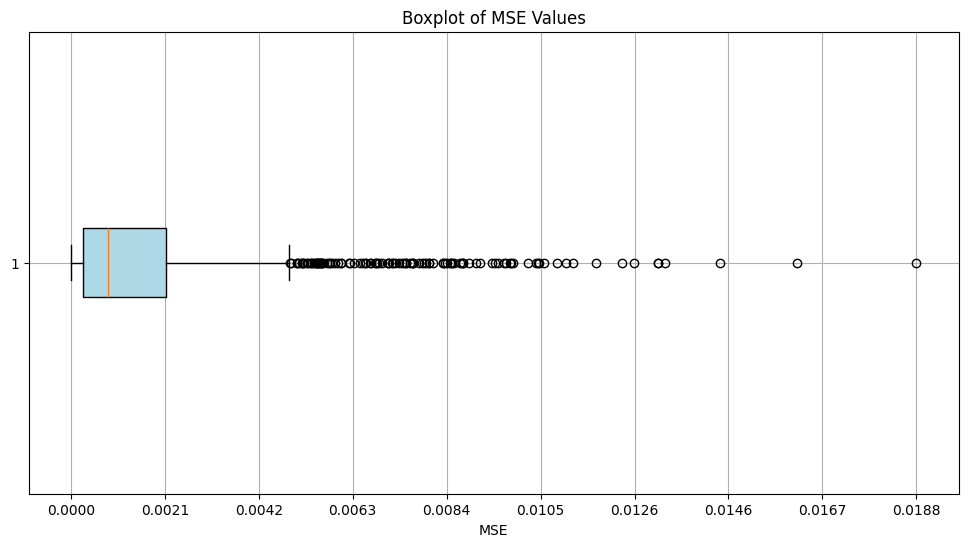

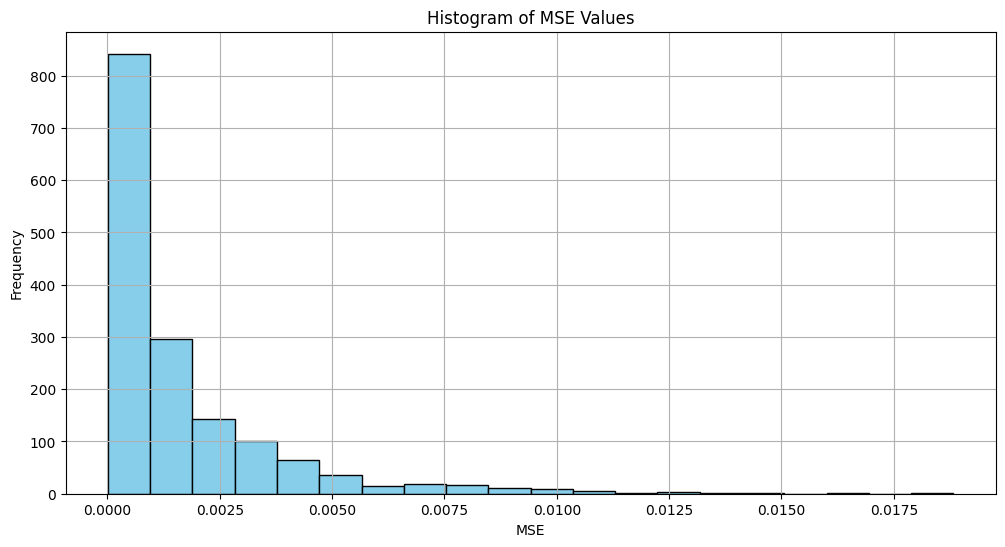

In [20]:
mse_stats = mse_statistics(x_real, predictions)


Number of vectors with high MSE (above upper whisker): 110
Number of vectors with low MSE (below or equal to upper whisker): 1457

Statistics for high MSE conditional vectors:
  Mean: [0.49549751 0.3924143  0.01770833]
  Median: [0.43446456 0.39480172 0.        ]
  Std: [0.21464057 0.21596775 0.07798785]
  Min: [0.19830993 0.01413967 0.        ]
  Max: [0.99751323 0.97253394 0.43452382]

Statistics for low MSE conditional vectors:
  Mean: [0.43744397 0.4618335  0.00552444]
  Median: [0.41639015 0.4775489  0.        ]
  Std: [0.16366634 0.21204912 0.04638001]
  Min: [0.         0.00644275 0.        ]
  Max: [1.         1.         0.64880955]


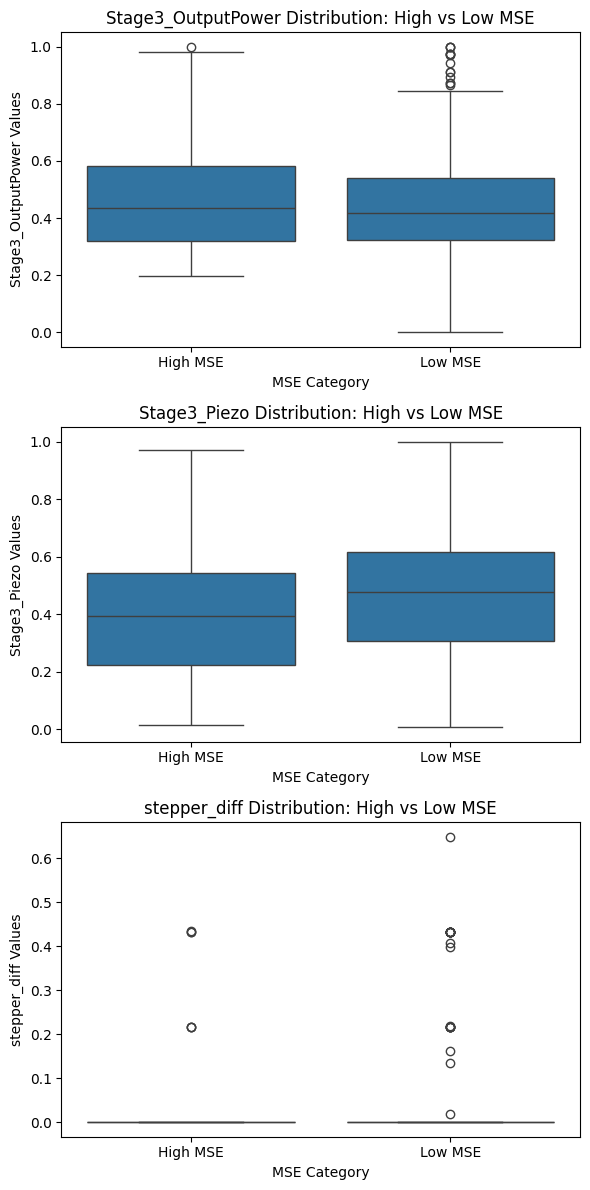

In [21]:
mse = np.mean((x_real - predictions) ** 2, axis=1)
parameter_names = ['Stage3_OutputPower', 'Stage3_Piezo', 'stepper_diff']
analyze_mse_and_cond_vectors(mse, cond_vectors, parameter_names)

## Try Random conditional vectors

In [22]:
df = pd.read_csv("../data/test_data_1024_[-1,1].csv")
df_subset = df.head(20)
new_cond_vectors = np.array([
    [ 214935.09855301,  269804.25447773, -418456.16068934],
    [ -93975.81857062,  120292.39937219,   82977.52669794],
    [ -93975.81857062,  -120292.39937219,   82977.52669794],
    [0,   0,   0],
    [  1,   1,  1],
    
    [ 1,    0,   0],
    [ 0,    1,   0],
    [ 0,    0,   1],
    [1,   1,   0],
    [  0,   1,  1],
    
    [ 1,    0,   1],
    [ 0.1,    0.1,   0],
    [ 0.3,    0.3,   0],
    [ 0.5,    0.5,   0],
    [ 0.7,    0.7,   0],
    
    [ 0.9,    0.9,   0],
    [ 0.1,    0.9,   0],
    [ 0.9,    0.1,   0],
    [ 0.5,    0.3,   0],
    [ 0.3,    0.5,   0],

])

df_subset['cond_vector'] = new_cond_vectors.tolist()
df_subset.to_csv("../data/data_nonsense.csv", index=False)

/tmp/ipykernel_2755021/1094714582.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cond_vector'] = new_cond_vectors.tolist()


In [23]:
df_subset

,time,idx,cond_vector,intensities
0,2024-06-17 10:11:38.558800220,18,"[214935.09855301, 269804.25447773, -418456.160...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
1,2024-06-17 10:20:03.601318836,80,"[-93975.81857062, 120292.39937219, 82977.52669...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
2,2024-06-17 10:15:08.508659840,48,"[-93975.81857062, -120292.39937219, 82977.5266...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
3,2024-06-17 10:12:54.698517799,40,"[0.0, 0.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
4,2024-06-17 10:17:33.703059673,57,"[1.0, 1.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
5,2024-06-17 10:23:07.478772640,116,"[1.0, 0.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
6,2024-06-17 10:25:01.330039501,119,"[0.0, 1.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
7,2024-06-17 10:16:29.521095276,57,"[0.0, 0.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
8,2024-06-17 10:13:30.400424957,40,"[1.0, 1.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
9,2024-06-17 10:22:44.214152813,101,"[0.0, 1.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."


In [24]:
x_real_nonsense, cond_vectors_nonsense, predictions_nonsense = evaluate(model,
                      sampler,
                      device,
                     "../data/data_nonsense.csv",
                                            s_type='edm')
x_real_nonsense = np.array(x_real_nonsense)
cond_vectors_nonsense = np.array(cond_vectors_nonsense)
predictions_nonsense = np.array(predictions_nonsense)[:,0,0,:]

Testing loop: 100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


In [25]:
predictions_nonsense

array([[-0.42708331,  0.36458337, -0.41666669, ...,  0.33072913,
         0.3359375 , -0.16666669],
       [ 0.88826811,  0.30446923, -0.55446929, ...,  0.46787715,
        -0.1913408 ,  0.58100557],
       [ 0.21810186, -0.38906348,  0.22564423, ...,  0.21307349,
         0.43683219, -0.17598993],
       ...,
       [-0.99758756, -0.9984802 , -0.9988296 , ..., -0.99738014,
        -0.99789745, -1.        ],
       [-0.99788058, -0.99927235, -1.        , ..., -0.99879831,
        -0.99766415, -0.99715632],
       [-0.99693412, -0.99771982, -0.99763656, ..., -0.99835968,
        -0.99873012, -0.99645895]])

In [26]:
x_real_nonsense

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

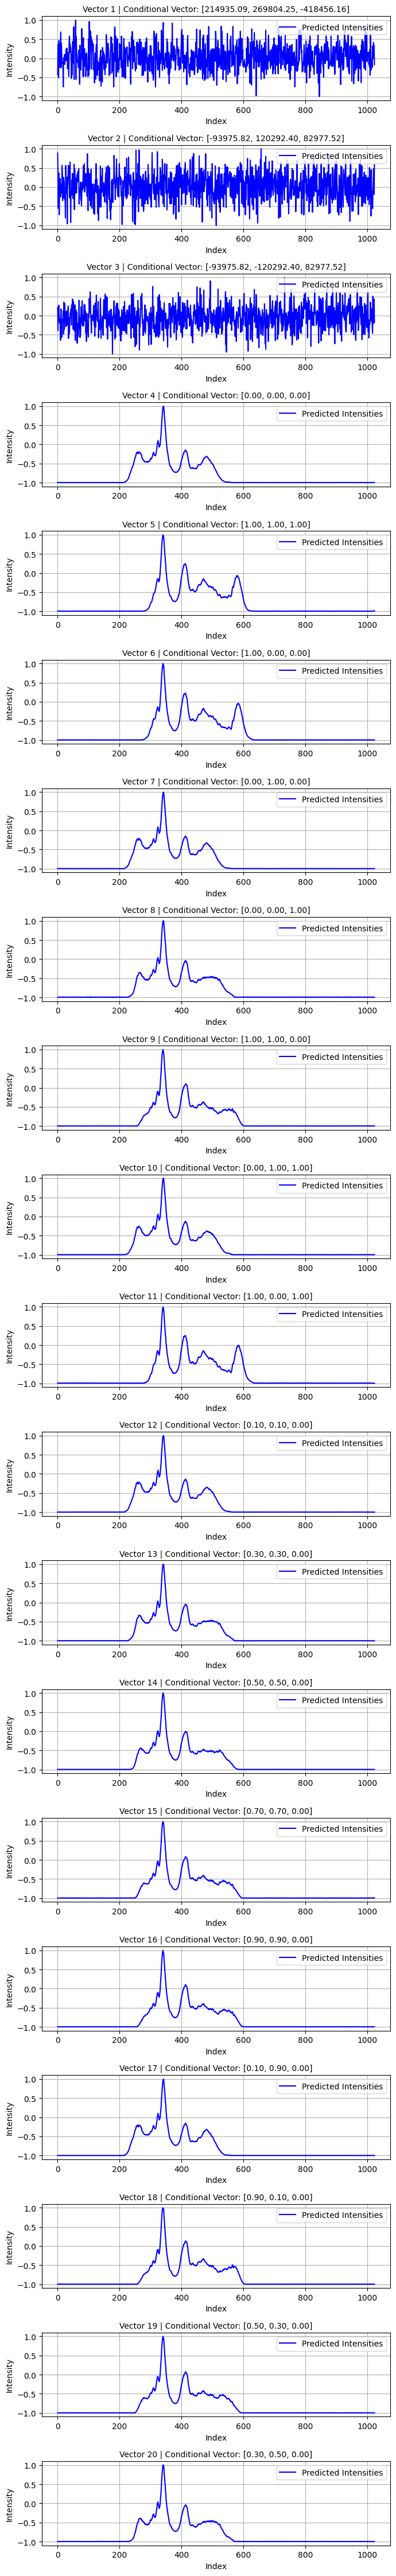

In [27]:
plot_predictions_with_cond_vectors(predictions_nonsense, cond_vectors_nonsense)

## Compare distributions

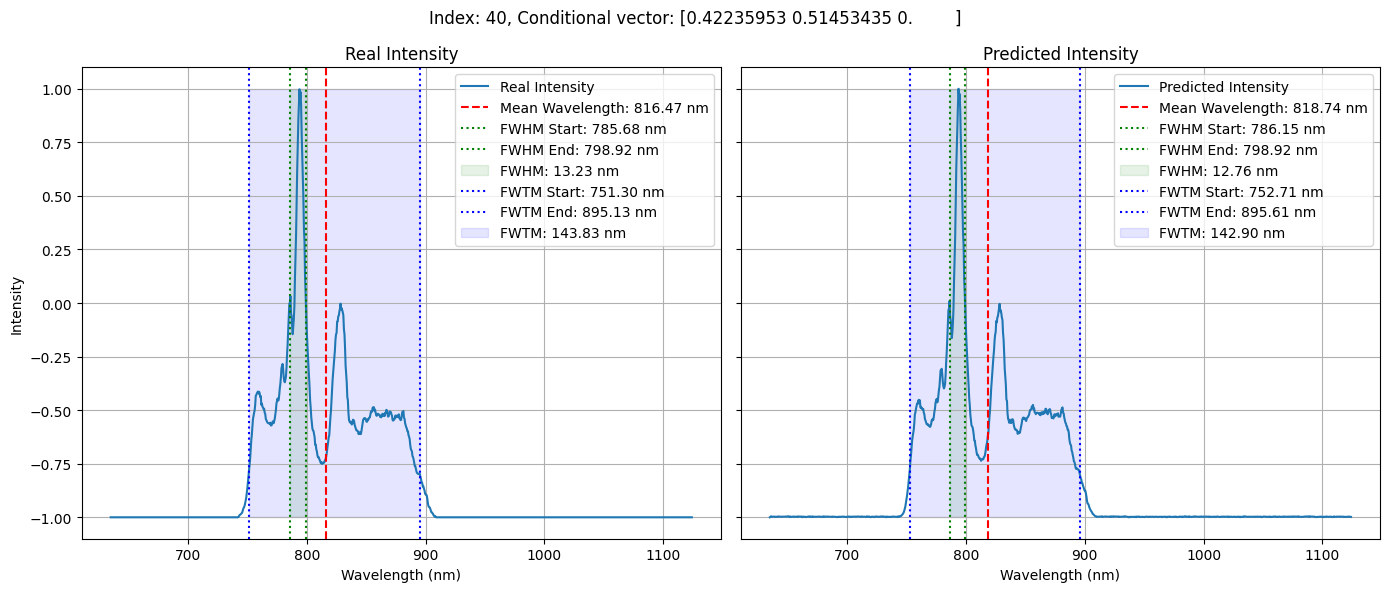

In [28]:
plot_comparison(index=40, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

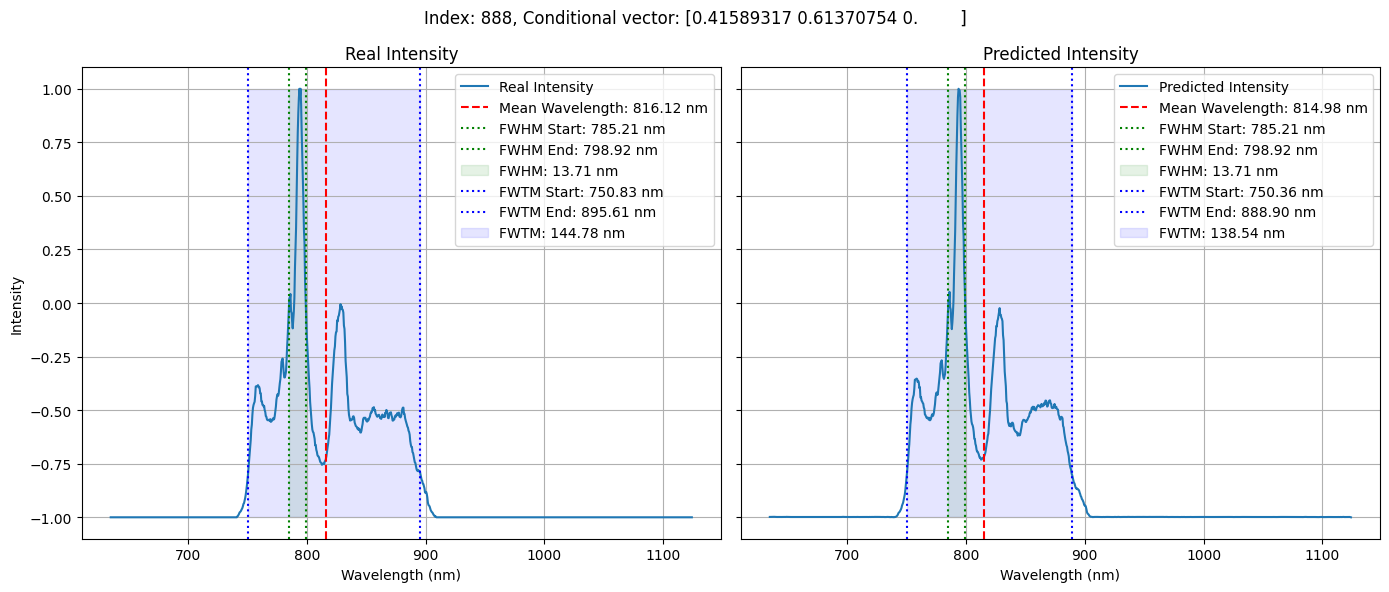

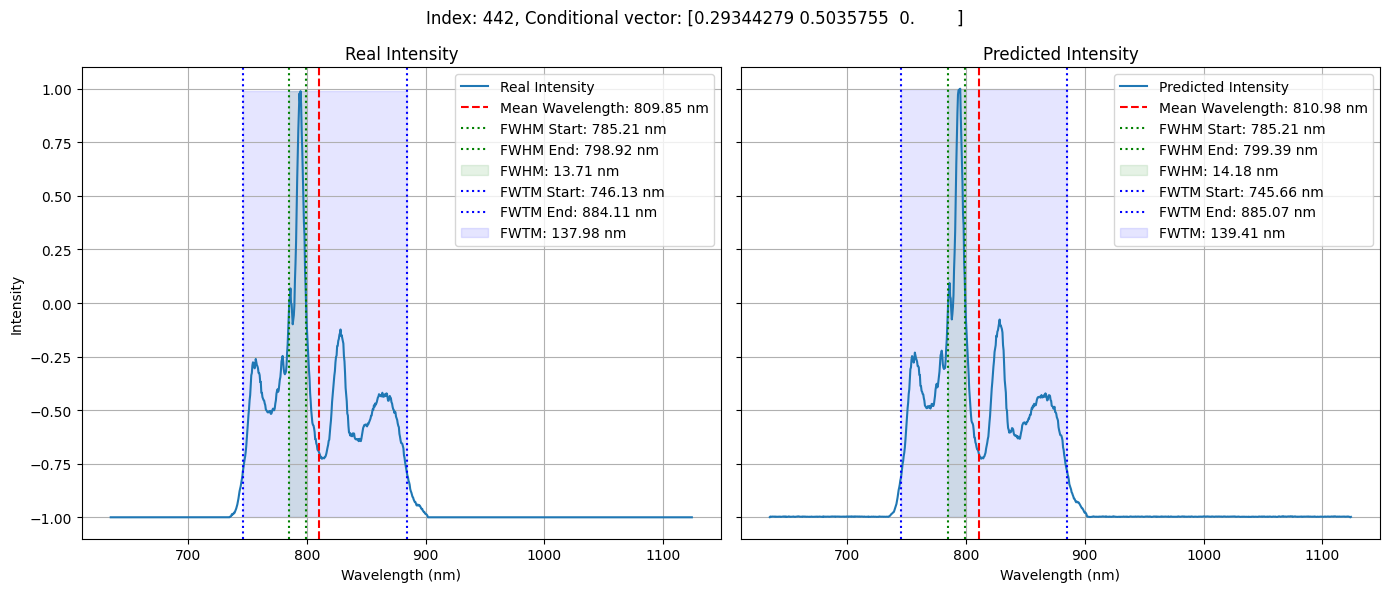

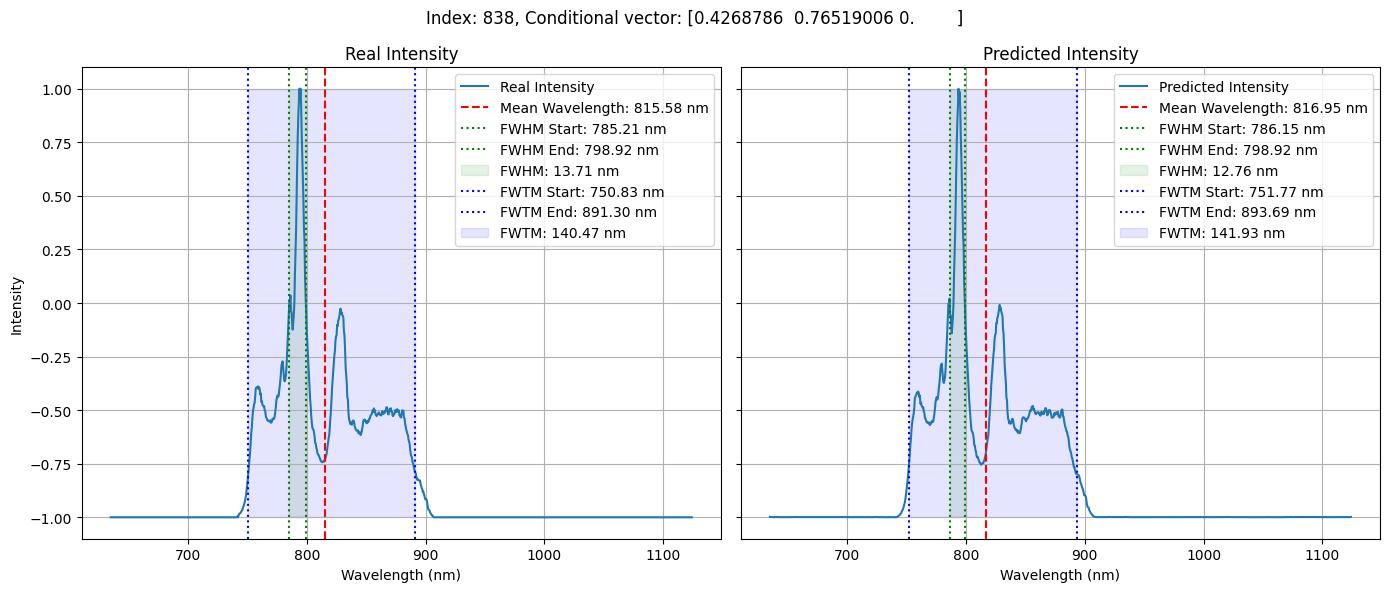

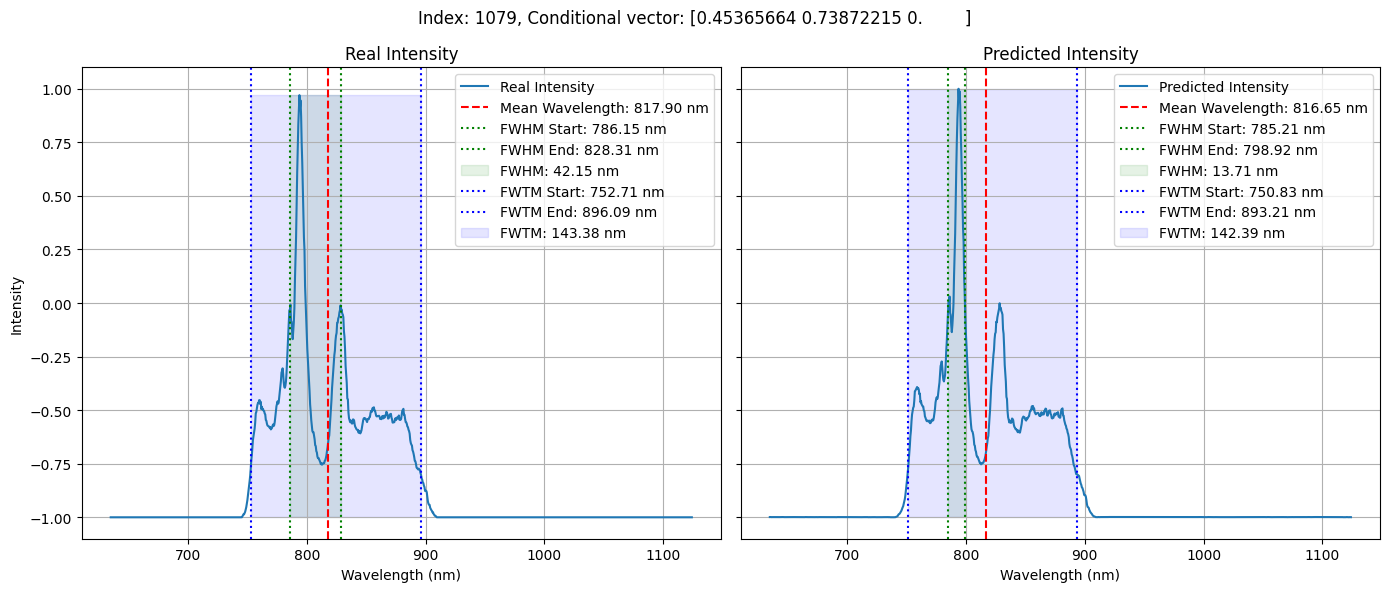

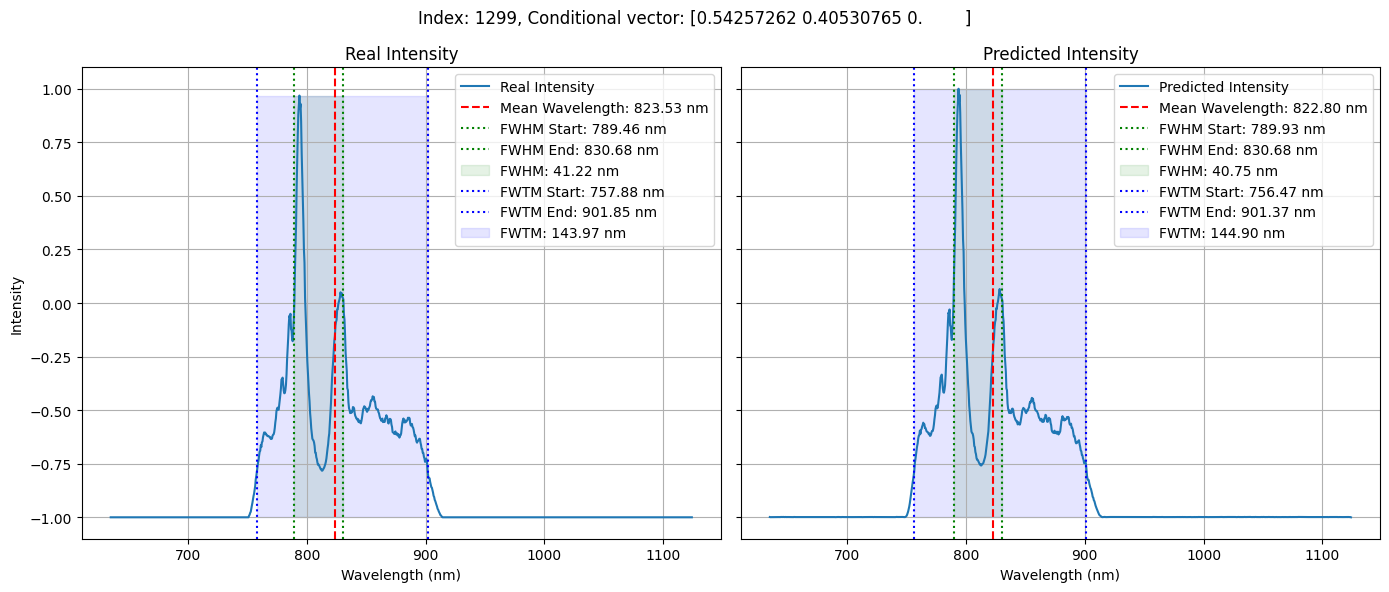

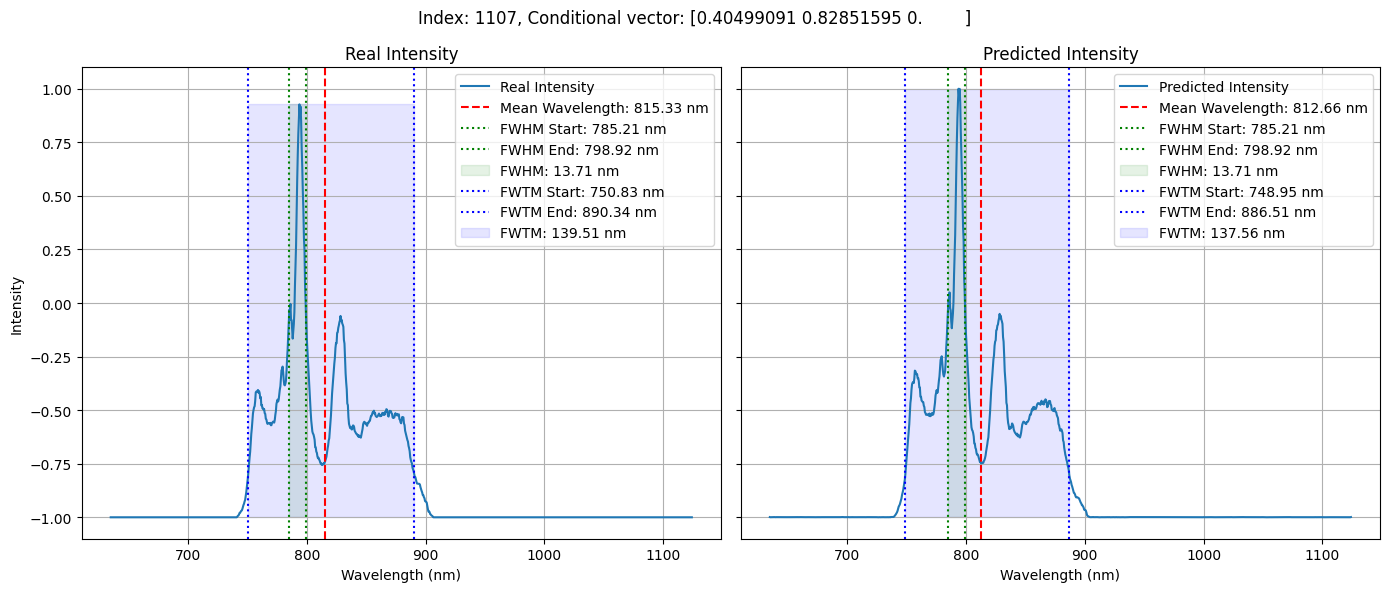

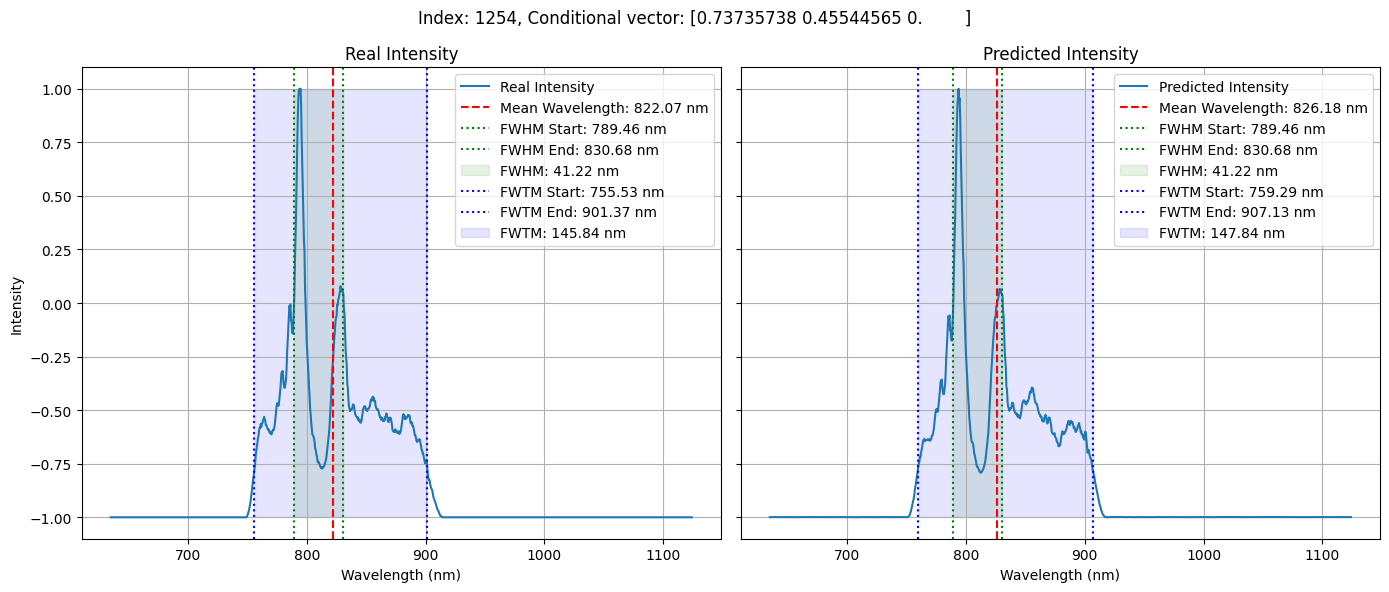

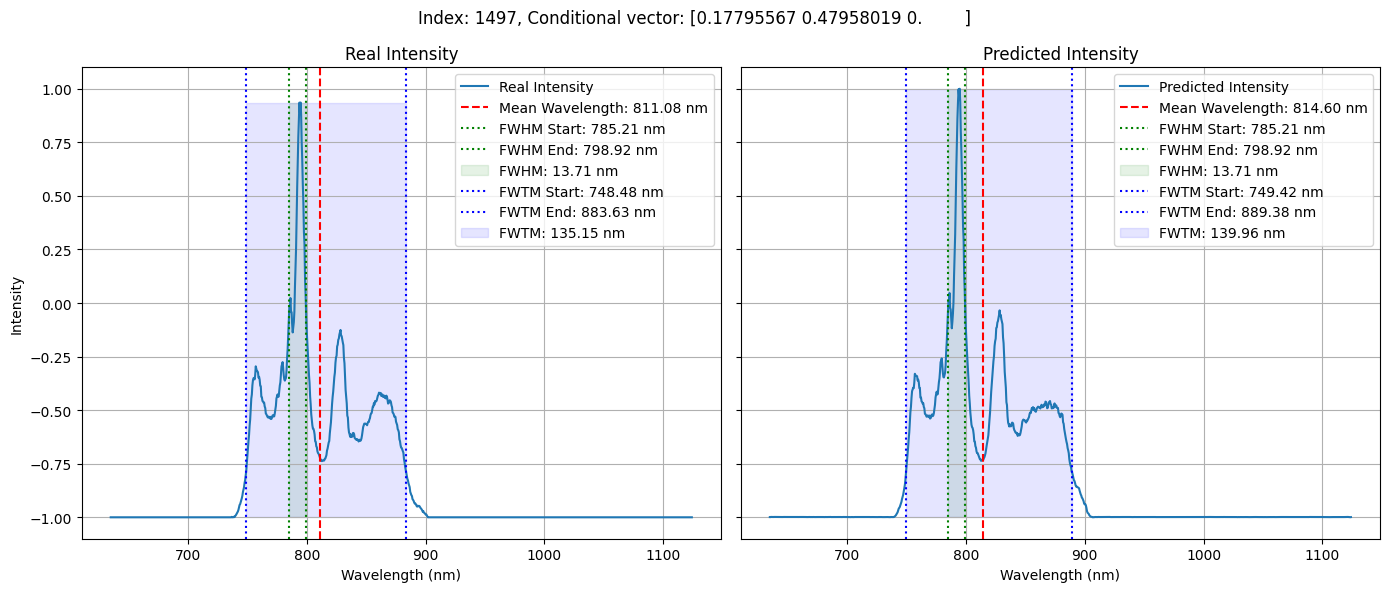

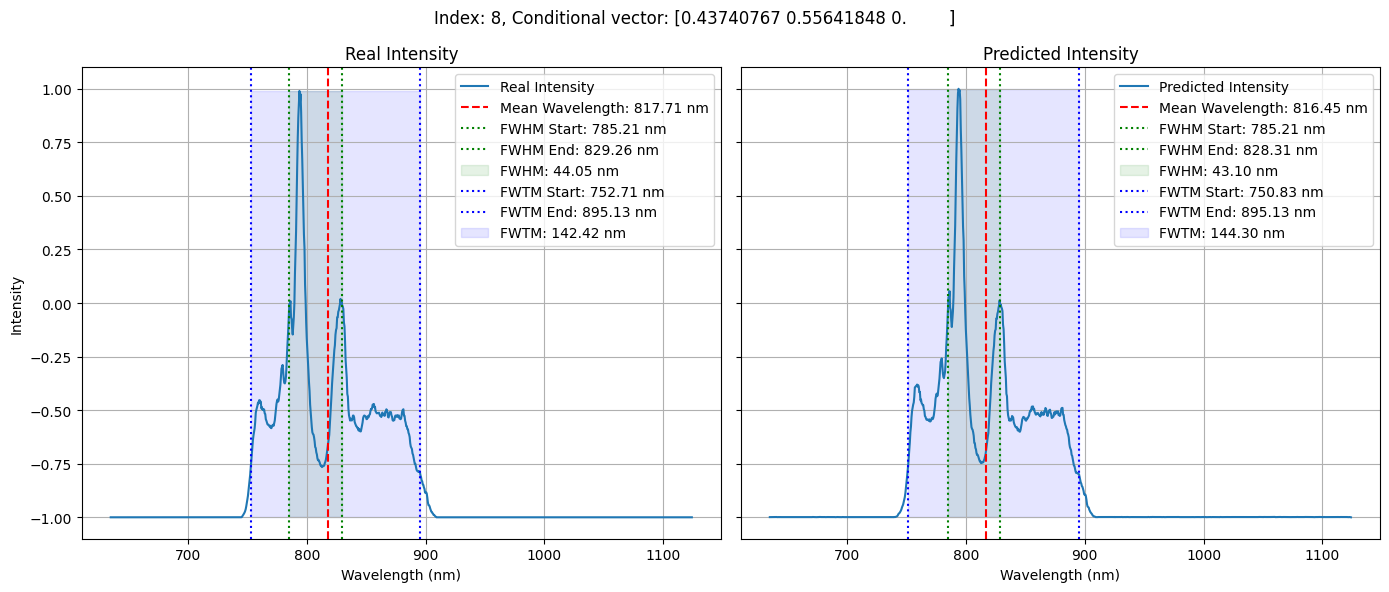

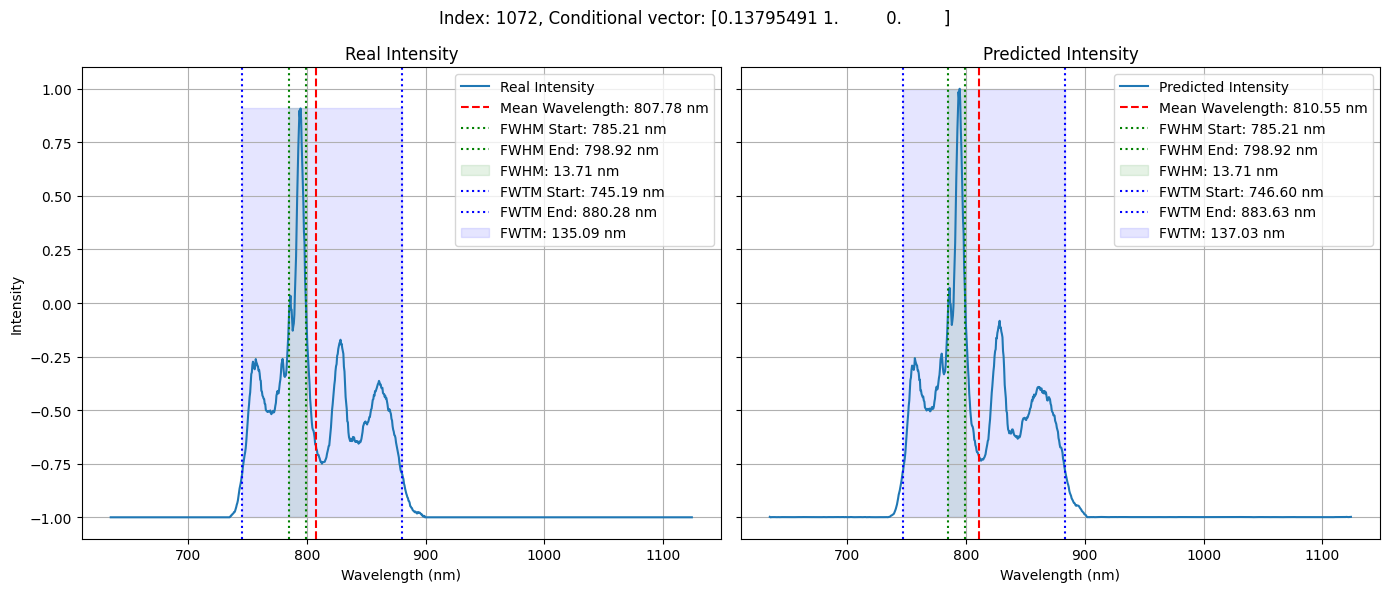

In [29]:
rand_ind = random.randint(len(x_real), size=(10))
for i in rand_ind:
    plot_comparison(index=i, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

In [30]:
# Calculate MSE and MAE for the metrics
mse_results, mae_results = calculate_metrics_errors(wavelengths, x_real, predictions)

+-----------------+-----------+---------+
| Metric          |       MSE |     MAE |
+=================+===========+=========+
| mean_wavelength |  19.3453  | 3.47212 |
+-----------------+-----------+---------+
| std_deviation   |   5.3941  | 1.98519 |
+-----------------+-----------+---------+
| fwhm            | 227.078   | 8.50332 |
+-----------------+-----------+---------+
| fwhm_start      |   4.21443 | 1.19235 |
+-----------------+-----------+---------+
| fwhm_end        | 247.828   | 8.33681 |
+-----------------+-----------+---------+
| fwtm            |  10.7259  | 2.47847 |
+-----------------+-----------+---------+
| fwtm_start      |  13.6667  | 2.83357 |
+-----------------+-----------+---------+
| fwtm_end        |  37.7092  | 4.82432 |
+-----------------+-----------+---------+


In [31]:
calculate_dtw_distances(x_real, predictions)

TypeError: unsupported operand type(s) for +: 'DTW' and 'DTW'